# Engenharia de Softwares Inteligentes - MVP - Titanic Challenge

Desafio, dados originais e detalhes da base disponiveis em:

https://www.kaggle.com/competitions/titanic

## Descrição
A base de dados utilizada é parte do _Titanic Challenge_, famoso desafio permanente do Kaggle.com para Machine Learning. O objetivo é que, a partir dos dados pessoais e de viagem de cada um dos passageiros do RMS Titanic, seja possível determinar a sobrevivência de cada um deles. Pela natureza subjetiva da escolha dos que teriam ou não acesso aos botes, não é possível estabelecer uma correlação plena, e valores muito elevados normalmente são sinais de que o teste estaria sobreajustado (overfitting). Contudo, a ordem inicial de carregamento dos botes foi dada por poucas pessoas ou uma única, o que nos permite deduzir um padrao. Serão criadas classes para demonstrar o potencial da utilização de boas práticas em Engenharia de Software. As classes servirão também para tratar dados fornecidos pelo usuário, que serão testados contra o modelo.<br>
Colunas:
-  Survival: Se a pessoa sobreviveu. Será nosso target.
-  Pclass: [1,2,3] Primeira, Segunda e Terceira Classe
-  Sex: Sexo do Passageiro
-  Age: Idade
-  SibSP: Irmãos e Conjuges
-  Parch: Filhos ou Pais
-  Ticket: Contem codigos que nao consegui explicar a natureza
-  Fare: Valor do ingresso
-  Cabin: Número da Cabine
-  Embarked: Inicial do porto de embarque. <br>

## Etapa I - Carga e Processamento dos Dados

In [2]:
# Configurações do notebook dentre outros
import warnings
warnings.filterwarnings("ignore")

# Imports gerais
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Imports específicos do Scikit-lean
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [3]:
# Arquivos do Kaggle
url = "https://raw.githubusercontent.com/tekoryu/rough-on-rats/main/data/titanic/train.csv"

# Carga no Pandas
df_treino = pd.read_csv(url, delimiter=',')

In [4]:
df_treino.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Pronomes de Tratamento

A classe, título ou qualificação do passegeiro pode ter sido fator preponderante para determinar se uma pessoa foi ou não escolhida para ir aos botes.

In [5]:
def pega_pronome_tratamento(entrada):
    # A entrada deve ser um dataframe. Pega o Mr. Mrs. e coloca em coluna própria
    pronome_tratamento = re.search(r' ([A-Za-z]+)\.',entrada)
    if pronome_tratamento:
        return pronome_tratamento.group(1)
    return ""

df_treino['Pronome'] = df_treino['Name'].apply(pega_pronome_tratamento)

Vejamos qual a distribuição desses pronomes entre os sobreviventes.

In [6]:
grouped = df_treino.groupby(['Pronome', 'Survived']).size().unstack(fill_value=0)
distribuicao = grouped.div(grouped.sum(axis=1), axis=0) * 100
distribuicao.drop(0, axis=1, inplace=True)
distribuicao
# Valores serão apresentados como % do total

Survived,1
Pronome,
Capt,0.000000
Col,50.000000
Countess,100.000000
Don,0.000000
Dr,42.857143
Jonkheer,0.000000
Lady,100.000000
Major,50.000000
Master,57.500000


Classificarei os passageiros, através do seu pronome pela probabilidade de ser poupado ou de se sacrificar, com base na lista acima. 5 para chances altas de se sacrificar até 1, para chances altas de ser poupado.

In [7]:
estoicismo = {
    'Capt': 5,
    'Col': 3,
    'Countess': 1,
    'Don': 5,
    'Dr': 3,
    'Jonkheer': 5,
    'Lady': 1,
    'Major': 3,
    'Master': 3,
    'Miss': 4,
    'Mlle': 1,
    'Mme': 1,
    'Mr': 2,
    'Mrs': 2,
    'Ms': 1,
    'Rev': 5,
    'Sir': 1
}
df_treino['Aval_Pronome'] = df_treino["Pronome"].apply(lambda x: estoicismo.get(x))

## Porto de Embarque
A  compreensão do porto de embarque pode ser relevante uma vez que praticamente toda a tripulação partiu de Southampton.

In [8]:
# Transforma o código do porto de embarque em escalar.
le = LabelEncoder()
df_treino["Embarked"] = df_treino["Embarked"].apply(lambda x: 'A' if x == 28.0 else x ) # Tinha uma linha com float ao inves de string
df_treino["cod_embarque"] = le.fit_transform(df_treino['Embarked'])

## Valor do Ticket
Os valores de ticket estao errados pois correspondem provavelmente ao valor de face (observe que quem viaja com família tem sempre tickets maiores). Vamos somar os integrantes da família e dividir por cabeça o valor do ticket.

In [9]:
df_treino["FixedFare"] = df_treino["Fare"]/(df_treino["SibSp"] + df_treino["Parch"] + 1)
df_treino["FixedFare"] = df_treino["FixedFare"].apply(np.round)

## Categorias de Idade
Vamos criar categorias de idade para agrupar os passageiros no que consideramos ser categorias de idade relevantes para o processo de escolha dos sobreviventes. Contudo há algumas idades que estão em branco. Vamos preencher a idade faltante com a mediana da idade das pessoas com aquele pronome de tratamento. 

In [10]:
# Pega a média das idades por pronome
pronomes = df_treino["Pronome"].unique()

# Pega a mediana por pronome
mediana = {}
for pronome in pronomes:
    mediana[pronome] = df_treino["Age"][df_treino["Pronome"] == pronome].median()

# Preenche as idades em branco com a media das idades para aquele pronome
df_treino['Age'] = df_treino.apply(lambda x: mediana[x['Pronome']] if pd.isna(x['Age']) else x['Age'], axis=1)

# Converte para inteiro
df_treino["Age"] = df_treino["Age"].astype(int)

# Cria uma feature nova, categorizando os passageiros em idades relevantes para a decisão de acesso ao bote.
df_treino["classe_idade"] = pd.cut(df_treino["Age"], bins=[-np.inf,5,10,13,60,np.inf], labels=["Colo","Nova","Jovem","Adulto", "Idoso"])

In [11]:
# Sobreviventes por classe de idade
grouped = df_treino.groupby(['classe_idade', 'Survived']).size().unstack(fill_value=0)
distribuicao = grouped.div(grouped.sum(axis=1), axis=0) * 100
distribuicao.drop(0, axis=1, inplace=True) # Não há necessidade da coluna de não-sobreviventes
distribuicao

Survived,1
classe_idade,
Colo,68.750000
Nova,35.000000
Jovem,57.142857
Adulto,36.901763
Idoso,22.727273


Agora é necessário transformar essas classes de idade em números. Uma abordagem bem conhecida é a utilização de `pd.get_dummies` ou `OneHotEncoder`. Contudo, testes anteriores demonstraram uma prevalência de algoritmos de Random Forest para esse desafio, que não é muito compatível com essas técnicas nesse contexto (perda de desempenho). Ainda, se não houverem tantas categorias no dataset de teste então os datasets terão tamanhos diferentes e poderão perder precisão. Por motivos de não-relação entre as categorias, não parece ser interessante o uso de escalares para a medição, pois levaria a uma falsa relação em algoritmos com o KNN.  Contudo, como acreditamos que o algoritmo RF terá o melhor desempenho, rotularemos com escalares mas não através do `LabelEncoder`, para garantir um mínimo de lógica em KNN.

In [12]:
cat_idades  = {
    'Colo': 1,
    'Nova': 2,
    'Jovem': 3,
    'Adulto': 4,
    'Idoso': 5,    
}

df_treino["classe_idade"] = df_treino["classe_idade"].map(cat_idades)

## Sexo
Em relação ao sexo dos passageiros, não haverá o problema de datasets em tamanhos diferentes, uma vez que não é provável que no dataset de testes tenha apenas um dos sexos. Nesse caso o uso de `get_dummies` não será um empecilho, contudo a binariedade de valores possíveis para sexo aqui permite criar uma única coluna com um e zero. Notar que não se fala aqui em gêneros, mas do sexo biológico.

In [13]:
df_treino["Sex"] = df_treino["Sex"].map({'male':1,'female':0})

## Outros fatores

É possível determinar se a pessoa viajou sozinha. É uma informação que pode melhorar o estudo já que pessoas viajando sozinhas poderiam ter dado vaga para um integrante de familia.

In [14]:
df_treino["Sozinho"] = np.where(df_treino["SibSp"]+df_treino["Parch"]==0,1,0)

## Limpeza
Vamos agora conseguir remover colunas desnecessárias para o treinamento.

In [15]:
df_treino.drop(["PassengerId","Name","Ticket","Cabin","Embarked", "Pronome"], axis=1, inplace=True)

## Tratamento de Null e em branco
Nota-se abaixo que não há colunas no dataframe.

In [16]:
df_treino.isna().sum(axis=0).sort_values(ascending=False)

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Aval_Pronome    0
cod_embarque    0
FixedFare       0
classe_idade    0
Sozinho         0
dtype: int64

## Análise dos dados
Vamos verificar se algum tipo de correlação se anunciou após todo o processo de engenharia dos atributos. Cores claras indicam correlação, proporcional ou inversamente proporcional.

<Axes: >

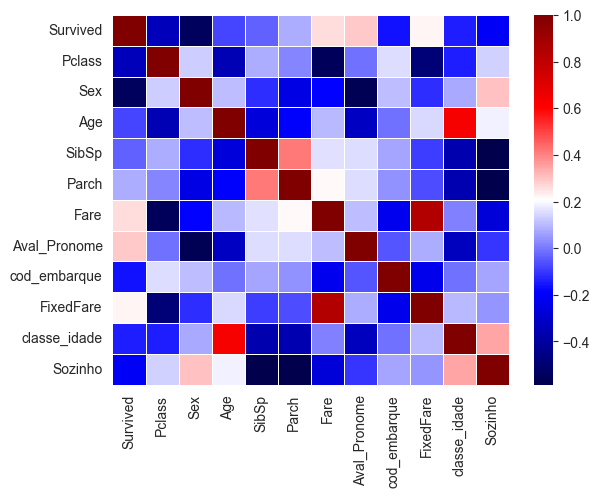

In [17]:
sns.heatmap(df_treino.corr(), linewidths=0.5, cmap='seismic')

***

## Holdout com particionamento

In [18]:
test_size = 0.2
seed = 3

# Separacao em conjunto de teste e treino
array = df_treino.values
X = array[:,1:12]
y = array[:,0]
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=test_size,
    random_state=seed,
    shuffle=True,
    stratify=y
)

scoring= 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

## Modelagem e Inferência

### Modelagem

In [19]:
np.random.seed(seed)

models = []

models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

### Inferência

In [20]:
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.795012 (0.043198)
KNN: 0.696674 (0.029111)
CART: 0.748768 (0.039129)
NB: 0.761209 (0.061425)
SVM: 0.667136 (0.040084)
Bagging: 0.793662 (0.036970)
RF: 0.789495 (0.037561)
ET: 0.779636 (0.038822)
Ada: 0.800548 (0.055229)
GB: 0.825880 (0.041212)
Voting: 0.789397 (0.038823)


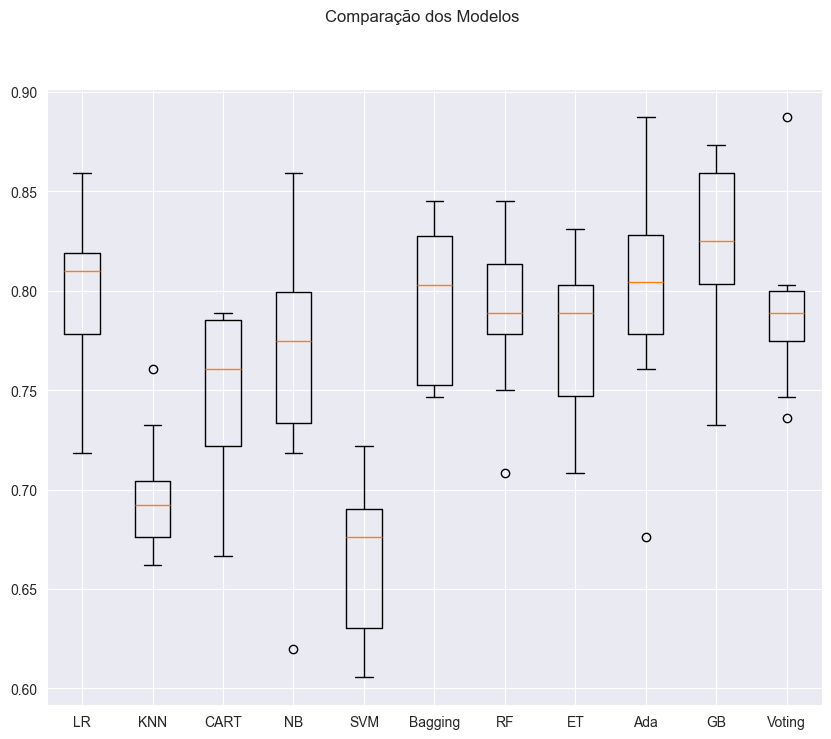

In [21]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(10,8))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Pipelines de Normalização dos dados e Hiperparametrização

Os algoritmos que mais se destacaram foram os de Gradient Booster, Ada e Logistic Regression. O resultado foi satisfatório, dentro dos parametros esperados.

`GB: 0.825880 (0.041212)`
`Ada: 0.800548 (0.055229)`
`LR: 0.795012 (0.043198)`


In [22]:
np.random.seed(seed)  # Definindo uma semente global para este bloco

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

### Execução das Pipelines de Normalização, Padronização e Hiperparametrizacao
Devido ao tamanho do arquivo se tornou melhor usar multiprocessing. Para desabilitar basta alterar o parametro njob para a quantidade de núcleos que preferir.

In [23]:
# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1,verbose=1 )
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo: LR-orig - Melhor: 0.807545 usando {'LR__C': 100, 'LR__solver': 'liblinear'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo: LR-padr - Melhor: 0.807545 usando {'LR__C': 10, 'LR__solver': 'liblinear'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo: LR-norm - Melhor: 0.807535 usando {'LR__C': 100, 'LR__solver': 'liblinear'}
Fitting 5 folds for each of 33 candidates, totalling 165 fits
Modelo: KNN-orig - Melhor: 0.740087 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Fitting 5 folds for each of 33 candidates, totalling 165 fits
Modelo: KNN-padr - Melhor: 0.804728 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Fitting 5 folds for each of 33 candidates, totalling 165 fits
Modelo: KNN-norm - Melhor: 0.810361 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 19}
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Modelo: CART-orig - Melhor: 0.

KeyboardInterrupt: 